# Session 2 — Relational Modeling & Data Types

Model an OLTP schema, define keys, and inspect constraints. Visualize table sizes.


## Environment Setup

In [1]:
import sys, sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt
print(sys.version)
import seaborn as sns
sns.set_theme()
from pathlib import Path
DB_PATH = Path('course.db')
conn = sqlite3.connect(DB_PATH)
conn.execute('PRAGMA foreign_keys=ON;')
print('SQLite ready at', DB_PATH.resolve())

3.11.9 (v3.11.9:de54cf5be3, Apr  2 2024, 07:12:50) [Clang 13.0.0 (clang-1300.0.29.30)]
SQLite ready at /Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/Phase1/Data_Engineering/course.db


In [2]:
def run_sql(q, params=None):
    params = params or {}
    df = pd.read_sql_query(q, conn, params=params)
    display(df)
    return df

## 1. Keys & Relationships
- **Primary Key (PK):** unique identifier in a table  
- **Foreign Key (FK):** references a PK in another table

We'll extend Session 1 by adding `orders`, `order_items`, and `shippers`.

In [3]:
conn.executescript('''
DROP TABLE IF EXISTS shippers;
DROP TABLE IF EXISTS orders;
DROP TABLE IF EXISTS order_items;
CREATE TABLE shippers(
  shipper_id INTEGER PRIMARY KEY,
  name TEXT NOT NULL
);
CREATE TABLE orders(
  order_id INTEGER PRIMARY KEY,
  customer_id INTEGER NOT NULL,
  order_date TEXT NOT NULL,
  shipper_id INTEGER,
  FOREIGN KEY(customer_id) REFERENCES customers(customer_id),
  FOREIGN KEY(shipper_id) REFERENCES shippers(shipper_id)
);
CREATE TABLE order_items(
  order_item_id INTEGER PRIMARY KEY,
  order_id INTEGER NOT NULL,
  product_id INTEGER NOT NULL,
  quantity INTEGER NOT NULL CHECK(quantity>0),
  FOREIGN KEY(order_id) REFERENCES orders(order_id),
  FOREIGN KEY(product_id) REFERENCES products(product_id)
);
INSERT INTO shippers(name) VALUES ('Postal Express'),('GoFast'),('Eagle Air');
INSERT INTO orders(customer_id,order_date,shipper_id) VALUES
 (1,'2024-10-01',1),(1,'2024-10-05',2),(2,'2024-11-02',2),(3,'2024-11-03',3);
INSERT INTO order_items(order_id,product_id,quantity) VALUES
 (1,1,2),(1,4,3),(2,3,1),(3,2,2),(4,3,1);
'''); conn.commit()
print("Extended schema created.")

Extended schema created.


## 2. Inspecting Schema

In [4]:
run_sql("PRAGMA table_info('orders');")
run_sql("PRAGMA foreign_key_list('order_items');")

,cid,name,type,notnull,dflt_value,pk
0,0,order_id,INTEGER,0,None,1
1,1,customer_id,INTEGER,1,None,0
2,2,order_date,TEXT,1,None,0
3,3,shipper_id,INTEGER,0,None,0


,id,seq,table,from,to,on_update,on_delete,match
0,0,0,products,product_id,product_id,NO ACTION,NO ACTION,NONE
1,1,0,orders,order_id,order_id,NO ACTION,NO ACTION,NONE


,id,seq,table,from,to,on_update,on_delete,match
0,0,0,products,product_id,product_id,NO ACTION,NO ACTION,NONE
1,1,0,orders,order_id,order_id,NO ACTION,NO ACTION,NONE


## 3. Quick Visual — Order Items by Product

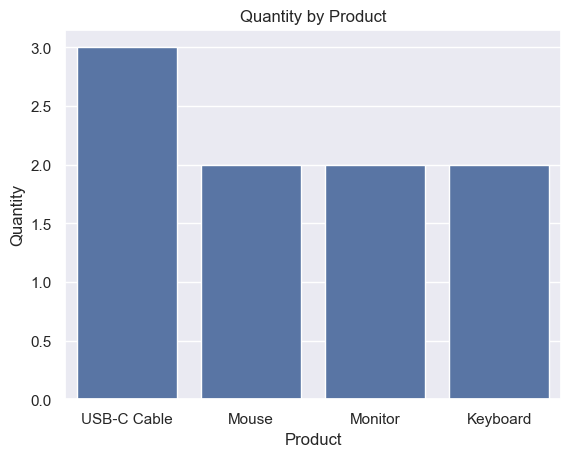

In [5]:
df = pd.read_sql_query('''
SELECT p.product, SUM(oi.quantity) AS qty
FROM order_items oi JOIN products p ON oi.product_id=p.product_id
GROUP BY p.product ORDER BY qty DESC;
''', conn)
sns.barplot(data=df, x="product", y="qty")
plt.title("Quantity by Product"); plt.xlabel("Product"); plt.ylabel("Quantity"); plt.show()